# Assignment 9

*Dency Claris Thomas*

*Dataset 6*

We can predict links based on available features in the graph. Please randomly delete 10% of the
edges in the graph, and use any features to train a conventional machine learning algorithm to predict
the deleted edges. Please output a report of the prediction accuracy, AUROC, precision and ROC
curve.

In [1]:
import networkx as nx

facebook_edge_file = "datasets/1684.edges"
facebook_ego_graph = nx.read_edgelist(facebook_edge_file)

print(f"Number of nodes: {facebook_ego_graph.number_of_nodes()}")
print(f"Number of edges: {facebook_ego_graph.number_of_edges()}")

Number of nodes: 157
Number of edges: 569


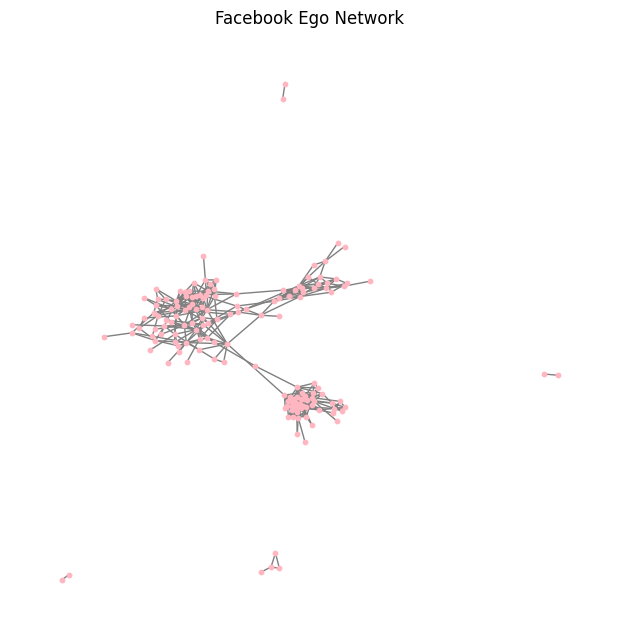

In [2]:
import matplotlib.pyplot as plt

# Plot the Network
plt.figure(figsize=(6,6))
nx.draw(facebook_ego_graph, with_labels = False, node_size = 10, node_color = 'lightpink', edge_color = 'gray')
plt.title('Facebook Ego Network')
plt.show()

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve, auc

# Randomly delete 10% of edges
edges = list(facebook_ego_graph.edges)
num_test_edges = int(0.1 * len(edges))
np.random.seed(42)
test_edges = np.random.choice(range(len(edges)), num_test_edges, replace = False)
test_edges = [edges[i] for i in test_edges]

# Remove the test edges from the graph
G_train = facebook_ego_graph.copy()
G_train.remove_edges_from(test_edges)


In [4]:
# Generate positive and negative samples
def generate_samples(graph, edges, label):
    features =[]
    for u, v in edges:
        common_neighbors = len(list(nx.common_neighbors(graph, u, v)))
        jaccard = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(graph, [(u, v)]))[0][2]
        features.append([common_neighbors, jaccard, adamic_adar, label])
    return features

In [5]:
# Positive samples (removed edges)
positive_samples = generate_samples(G_train, test_edges, 1)

In [6]:
# Generate random non-edges as negative samples
non_edges = list(nx.non_edges(G_train))
np.random.shuffle(non_edges)
negative_samples = generate_samples(G_train, non_edges[:num_test_edges], 0)

In [7]:
# Combine and split dataset
samples = positive_samples + negative_samples
X = [sample[:1] for sample in samples]
y = [sample[-1] for sample in samples]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
# Train the model
clf = RandomForestClassifier(random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Evaluate the model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print(f"Precision: {precision:.2f}")

Accuracy: 0.91
AUROC: 0.93
Precision: 0.95


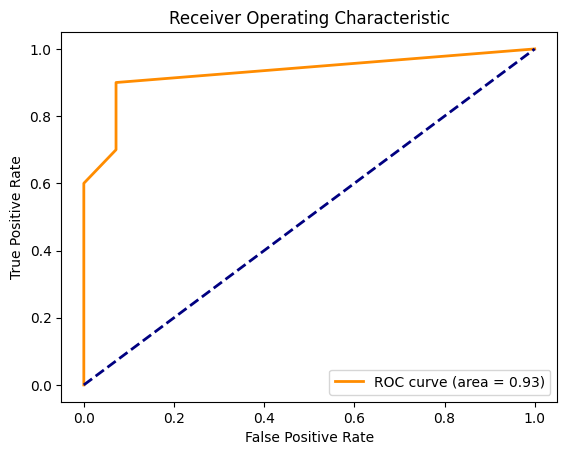

In [10]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()